# Imports

In [1]:
import cv2
import numpy as np
import glob, os
import os.path as osp
import matplotlib.pyplot as plt
import collections
import pandas as pd

from skimage import color, data, restoration
from scipy.signal import convolve2d as conv2
from scipy.misc import imread, imsave
from skimage.exposure import equalize_hist
from tqdm.notebook import tqdm


# Paths
Paths to various image enhancement algorithms applied over the low quality chess board image

In [ ]:
_CHESSBOARD_IM_DIR = "/home/ramana95/SafeCity/retinatracker/data/chessboard/CalibIM_Copy"
imgs = glob.glob(os.path.join(_CHESSBOARD_IM_DIR,'*.png'))
save_dir_wiener = "/home/ramana95/SafeCity/retinatracker/data/chessboard/weiner_deconv"
savedir_rldeconv = "/home/ramana95/SafeCity/retinatracker/data/chessboard/RL_Deconv"
savedir_deblurgan = "/home/ramana95/SafeCity/retinatracker/data/chessboard/DeblurGAN/"
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 0.001)

Helper functions

In [75]:
def skimage_cv2(img):
    return np.clip(img*255., 1.0, 255.0).astype('uint8')
    
def retrieve_relevant_imgs(imgs, plot=True):
    """
    Amongst the enhanced images, select the ones where chessboard corners can be
    detected.
    """
    count = 0
    paths = []
    for ims in imgs:
        cur_im = cv2.cvtColor(cv2.imread(ims), cv2.COLOR_BGR2RGB)
#         cur_im = skimage_cv2(equalize_hist(cur_im))
        im_name = ims.split("/")[-1]
        h, w = cur_im.shape[:-1]
        cropped_img = cur_im[h//2:, w//2:, :]
        cur_im_gray = cv2.cvtColor(cur_im, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(cur_im, (3,3), None)
        if ret == True:
            print(ims)
            paths.append(ims)
            count += 1
            if plot == True:
                corners2 = cv2.cornerSubPix(cur_im_gray, corners, (3,3), (-1,-1), criteria)
                img = cv2.drawChessboardCorners(cur_im, (3,3), corners2, ret)
                cv2.imwrite(im_name, img)
                # cv.waitKey(500)
    print("Count is : " + str(count))
    return paths

def corner_detect_harris(imgs, plot=True):
    """
    chessbaord corner detection using Harris corner algorithm
    """
    for ims in imgs:
        cur_im = cv2.imread(ims)
        h, w = cur_im.shape[:-1]
        cur_im = cur_im[h//2:, w//2:1020, :]
        cur_im_gray = cv2.cvtColor(cur_im, cv2.COLOR_BGR2GRAY)
        im_name = ims.split("/")[-1]
        corners = cv2.goodFeaturesToTrack(cur_im_gray, 10, 0.01, 20*0.001)
        corners = np.int0(corners)
        for i in corners:
            x,y = i.ravel()
            cv2.circle(cur_im, (x,y),3,255,-1)
            save_name = "harris_corner_cropped" + im_name
            cv2.imwrite(save_name, cur_im)

def apply_weiner(imgs, save_dir):
    """
    Apply weiner deconvolution to enhance image quality
    """
    for ims in imgs:
        im_name = ims.split("/")[-1]
        astro = color.rgb2gray(imread(ims))
        psf = np.ones((5, 5)) / 25
        astro = conv2(astro, psf, 'same')
        astro += 0.1 * astro.std() * np.random.standard_normal(astro.shape)
        deconvolved, _ = restoration.unsupervised_wiener(astro, psf)
        imsave(os.path.join(save_dir, im_name), color.gray2rgb(deconvolved))

def apply_RLdeconv(imgs, save_dir):
    """
    Apply RL deconvolution to enhance image quality.
    """
    for ims in imgs:
        im_name = ims.split("/")[-1]
        astro = color.rgb2gray(imread(ims))
        psf = np.ones((5, 5)) / 25
        astro = conv2(astro, psf, 'same')
        # Add Noise to Image
        astro_noisy = astro.copy()
        astro_noisy += (np.random.poisson(lam=25, size=astro.shape) - 10) / 255.

        # Restore Image using Richardson-Lucy algorithm
        deconvolved_RL = restoration.richardson_lucy(astro_noisy, psf, iterations=30)
        imsave(os.path.join(save_dir, im_name), color.gray2rgb(deconvolved_RL))


def check_and_add(raw_paths, enhanced_paths):
    """
    Avoid adding duplicate enhanced images
    """
    img_dict = {}
    raw_imgs = [i.split("/")[-1] for i in raw_paths]
    enhance_imgs = [j.split("/")[-1] for j in enhanced_paths]
    img_dict['raw_fname'] = raw_paths
    extra_imgs = set(enhance_imgs) - set(raw_imgs)
    final_dict = {pref:ele for pref in extra_imgs for ele in enhanced_paths if pref in ele}
    final_list = list(final_dict.values()) + raw_paths 
    return final_list


def create_dict_from_path(final_list):
    d = collections.defaultdict(list)
    [d[osp.basename(osp.dirname(f))].append(f) for f in final_list]
    return d

Get the enhanced images and add the relevant ones, create a dict

In [15]:
# apply_RLdeconv(imgs, savedir_rldeconv)


wiener_imgs = glob.glob(os.path.join(save_dir_wiener,'*.png'))
deblurgan_imgs = glob.glob(os.path.join(savedir_deblurgan,'*.png'))
rl_imgs = glob.glob(os.path.join(savedir_rldeconv,'*.png'))
enhanced_images = []
enhanced_images += retrieve_relevant_imgs(deblurgan_imgs)
print("break \n")
enhanced_images += retrieve_relevant_imgs(wiener_imgs)
print("break \n")
orig_images = retrieve_relevant_imgs(imgs)
print("break \n")
enhanced_images += retrieve_relevant_imgs(rl_imgs)

total_imgs = check_and_add(orig_images, enhanced_images)
print(total_imgs)
print(len(total_imgs))
method_path_dict = create_dict_from_path(total_imgs)

['/home/ramana95/SafeCity/retinatracker/data/chessboard/weiner_deconv/000099.png', '/home/ramana95/SafeCity/retinatracker/data/chessboard/RL_Deconv/001087.png', '/home/ramana95/SafeCity/retinatracker/data/chessboard/weiner_deconv/000141.png', '/home/ramana95/SafeCity/retinatracker/data/chessboard/RL_Deconv/000101.png', '/home/ramana95/SafeCity/retinatracker/data/chessboard/RL_Deconv/001283.png', '/home/ramana95/SafeCity/retinatracker/data/chessboard/DeblurGAN/000161.png', '/home/ramana95/SafeCity/retinatracker/data/chessboard/CalibIM_Copy/001472.png', '/home/ramana95/SafeCity/retinatracker/data/chessboard/CalibIM_Copy/000121.png', '/home/ramana95/SafeCity/retinatracker/data/chessboard/CalibIM_Copy/000021.png', '/home/ramana95/SafeCity/retinatracker/data/chessboard/CalibIM_Copy/000299.png', '/home/ramana95/SafeCity/retinatracker/data/chessboard/CalibIM_Copy/000001.png']
11


## Camera calibration

In [16]:
# Calib utility
all_img_pts, all_obj_pts, all_shape, im_names = [], [], [], []

def get_imgobj_points(images, objp, save=False):
    """
    Find corner points of chess board in enhanced images
    """
    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 0.001)
    shape = None
    im_names = []
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    c_count = 0
    for fname in images:
        img = cv2.cvtColor(cv2.imread(fname),cv2.COLOR_BGR2RGB)
        imname = fname.split("/")[-1].split(".")[0]
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        shape = gray.shape
        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(img, (3,3), None)
        # If found, add object points, image points (after refining them)
        if ret == True:
            c_count += 1
            # objpoints.append(objp)
            # imgpoints.append(corners)
            corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
            imgpoints.append(corners)
            objpoints.append(objp)
            img = cv2.drawChessboardCorners(img, (3,3), corners2, ret)
            if save:
                cv2.imwrite(imname+".png", img)
            # cv.waitKey(500)
            im_names.append(imname)
    print(c_count)
    return imgpoints, objpoints, shape, im_names


def reprojection_error(objpoints, imgpoints, *args):
    """
    Get reprojection error from the computed matrix
    """
    mean_error = 0
    reproj_error = []
    for i in range(len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(objpoints[i], args[3][i], args[4][i], args[1], args[2])
        error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
        reproj_error.append(error)
    return reproj_error

for method, paths in method_path_dict.items():
    print("Performing calib for %s" %method)
    objp = np.zeros((3*3,3), np.float32)
    objp[:,:2] = np.mgrid[0:3,0:3].T.reshape(-1,2)
    objp = objp.reshape(-1,1,3)
#     get_imgobj_points(paths, objp)
    impts, obpts, shape, imname = get_imgobj_points(paths, objp)
    all_img_pts += impts
    all_obj_pts += obpts
    im_names += imname
    
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(all_obj_pts, all_img_pts,
                                                   shape[::-1], None, None)

_, rvec, tvec = cv2.solvePnP(np.vstack(all_obj_pts), np.vstack(all_img_pts), mtx, dist)
# rmat = cv2.Rodrigues(rvec)
ext_mat = np.dot(np.squeeze(rvec), np.column_stack((np.identity(3), tvec)))
proj_mat = np.dot(mtx, ext_mat)
np.save('cam_mat.txt', mtx)

Performing calib for weiner_deconv
2
Performing calib for RL_Deconv
3
Performing calib for DeblurGAN
1
Performing calib for CalibIM_Copy
5


ValueError: shapes (3,3) and (4,) not aligned: 3 (dim 1) != 4 (dim 0)

### Plot reprojection error

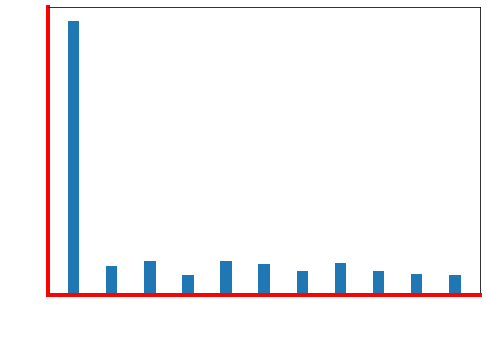

In [133]:
# len(obpts)
import matplotlib.pyplot as plt

def plot_hist(y_axis, im_names):
    fig = plt.figure()
    width = 0.3
    ax = fig.add_axes([0,0,1,1])
    x_axis = [str(i)[-4:] for i in im_names]
    ax.bar(x_axis, y_axis, width)
    plt.xlabel("Image Name", fontsize=14)
    plt.ylabel("Reprojection Error in pixels", fontsize=14)
    plt.yticks(np.linspace(0.5, 8, 16))
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.spines['bottom'].set_color('red')
    ax.spines['left'].set_color('red')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.spines["bottom"].set_linewidth(4.)
    ax.spines["left"].set_linewidth(4.)
    plt.show()
    fig.savefig("reproj_error.png", dpi=100)


reproj_errors = reprojection_error(all_obj_pts, all_img_pts,ret, mtx, dist, rvecs, tvecs)
plot_hist(reproj_errors,im_names)

### Compute depth from monocular images using monodepth 
### Then compute trajectory's 3D coordinate and plot them

In [18]:
all_npy_files = glob.glob("./data/chessboard/depth_mono_1024320/*.npy")

all_depth = []
# calculate average depth matrix
for npy_file in all_npy_files:
    depth_ar = np.load(npy_file)
    all_depth.append(np.squeeze(depth_ar))
#     print(str(np.max(depth_ar)) + "\t" + str(np.min(depth_ar)) + "\t" + str(np.mean(depth_ar)))
all_depth = np.array(all_depth)
mean_depth = np.mean(all_depth, axis=0)

### Save the computed 3D coordiantes into a CSV file

In [24]:

csv_file = "/home/ramana95/SafeCity/frame_sorted.csv"
focal_length_x, focal_length_y = mtx[0][0], mtx[1][1]
pd_read = pd.read_csv(csv_file)
pd_read.insert(11, "X_cam", 0)
pd_read.insert(12, "Y_cam", 0)
pd_read.insert(13, "Z_cam", 0)
pd_read.X_cam.astype(np.float32)
pd_read.Y_cam.astype(np.float32)
pd_read.Z_cam.astype(np.float32)


for index, rows in tqdm(pd_read.iterrows()):
    cur_x, cur_y = rows['x'], rows['y']
    depth_pix = mean_depth[cur_y][cur_x]
    pd_read.set_value(index,'Z_cam', float(depth_pix))
    pixel_ar = np.array([cur_x, cur_y, 1])
    x_cam, y_cam = [(im_cord - o_center)*(depth_pix / f_len) \
                    for im_cord, o_center, f_len in zip([cur_x, cur_y],
                                                       [mtx[0][2], mtx[1][2]],
                                                        [mtx[0][0], mtx[1][1]])]
    pd_read.set_value(index,'X_cam', np.float32(x_cam))
    pd_read.set_value(index,'Y_cam', np.float32(y_cam))
pd_read.to_csv("prespective_trajectories.csv")


/home/ramana95/anaconda3/envs/tinyface/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()
/home/ramana95/anaconda3/envs/tinyface/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/ramana95/anaconda3/envs/tinyface/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


### Randomly plot the 3D coordinates of a few trajectories 

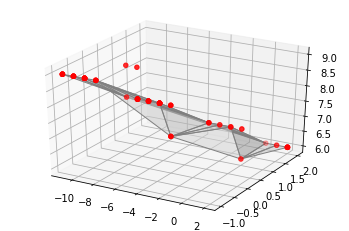

<Figure size 432x288 with 0 Axes>

In [141]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

track_sorted = pd_read.sort_values(by='track_id')
success_trackid = 57
failed_trackid = 68
x_cam_10 = track_sorted.loc[track_sorted['track_id'] == success_trackid, 'X_cam']
y_cam_10 = track_sorted.loc[track_sorted['track_id'] == success_trackid, 'Y_cam']
z_cam_10 = track_sorted.loc[track_sorted['track_id'] == success_trackid, 'Z_cam']

# Plot X,Y,Z
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(x_cam_10, y_cam_10, z_cam_10, color='white', edgecolors='grey', alpha=0.5)
ax.scatter(x_cam_10, y_cam_10, z_cam_10, c='red')
plt.show()
plt.draw()
fig.savefig("/home/ramana95/Pictures/Diagrams/SafeCity/Trajectories/accurate_3D.png", dpi=100)

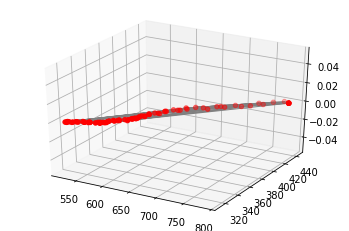

<Figure size 432x288 with 0 Axes>

In [143]:
fig = plt.figure()
ax = fig.gca(projection='3d')
x_img_10 = track_sorted.loc[track_sorted['track_id'] == success_trackid, 'x']
y_img_10 = track_sorted.loc[track_sorted['track_id'] == success_trackid, 'y']
z_zero = np.zeros_like(x_img_10)
ax.plot_trisurf(x_img_10, y_img_10, z_zero, color='white', edgecolors='grey', alpha=0.5)
ax.scatter(x_img_10, y_img_10, z_zero, c='red')
plt.show()
plt.draw()
fig.savefig("/home/ramana95/Pictures/Diagrams/SafeCity/Trajectories/accurate_pix.png", dpi=100)